# 2018-11-26 Debugs in the Spiking LGN scripts
J'ai des valueerrors étranges a répétition, on va faire quelques tests pour s'assurer que le framework de base qu'on utilise marche au moins.

# CONCLUSIONS :
C'était un problème double : mauvaise manière de calculer la convolution en utilisant deux espaces différents, qui parfois ne s'overlappaient pas. Résolu en utilisant un produit de Konecker entre le subspace de l'image qui la retaille pour le mettre au niveau du filtre. Le soucis c'est que ça donne des temps de calculs supplémentaires.

Second problème, j'étais pas assez précautionneux dans mes distances, donc a partir de maintenant la distance de sécurité est deux fois la distance de distribution, ce qu'on vendra comme des filtres fovéals.

# Premier test, la conversion de video a stimuli avec FPS
Ca se trouve j'ai merdé des dimensions ? on va voir avec le vidéo brute

# OK ici

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

total_time = 1000
FPS = 24.

In [2]:
#first we import the video
video = np.load('./MotionClouds_64x64x128_24FPS.npy')
video.shape

(64, 64, 128)

In [3]:
frame_duration = int(total_time/FPS)
stimuli = []
for ms in range(int(total_time/frame_duration)):
    for same_frame in range(frame_duration):
        stimuli.append(video[:, :, ms])
while len(stimuli) < total_time:
    stimuli.append(stimuli[-1])
if stimuli[0][30, 30] != stimuli[frame_duration+1][30, 30] :
    print('FPS difference sanity check passed !\n')
if stimuli[456][30, 30] == stimuli[457][30, 30] :
    print('FPS identity sanity check passed !\n')

#print(np.swapaxes(np.asarray(stimuli).T, 0,1).shape)
stimuli = np.swapaxes(np.asarray(stimuli).T, 0, 1)
print('Stimuli shape',stimuli.shape)

FPS difference sanity check passed !

FPS identity sanity check passed !

Stimuli shape (64, 64, 1000)


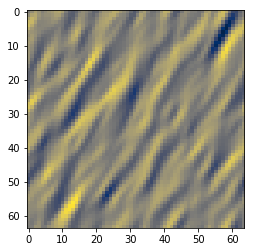

In [4]:
plt.imshow(stimuli[:,:,31], cmap = plt.cm.cividis)

%matplotlib notebook

Traceback (most recent call last):
  File "/home/hugo/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/home/hugo/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 999, in _start
    self._init_draw()
  File "/home/hugo/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1746, in _init_draw
    raise RuntimeError('The init_func must return a '
RuntimeError: The init_func must return a sequence of Artist objects.


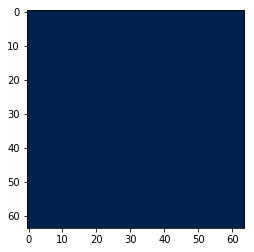

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

fig = plt.figure()

im = plt.imshow(stimuli[:,:,0] , cmap=plt.cm.cividis)

def init():
    im.set_data(np.zeros((64,64)))

def animate(i):
    im.set_data(stimuli[:,:,i])
    plt.title('Time (ms) = %s'% i)
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               interval=1, blit = True, save_count = 500)


Traceback (most recent call last):
  File "/home/hugo/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/home/hugo/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 999, in _start
    self._init_draw()
  File "/home/hugo/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1746, in _init_draw
    raise RuntimeError('The init_func must return a '
RuntimeError: The init_func must return a sequence of Artist objects.


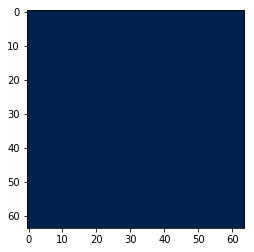

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

fig = plt.figure()

im = plt.imshow(video[:,:,0] , cmap=plt.cm.cividis)

def init():
    im.set_data(np.zeros((64,64)))

def animate(i):
    im.set_data(video[:,:,i])
    plt.title('Time (ms) = %s'% i)
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, blit = True,
                               interval=10, repeat = True )
#anim.save('./figs/mc_anim.gif', writer = 'imagemagick', dpi = 50, fps = 120)

# Second test, distance de sécurité des bords
Ca se trouve il suffit juste d'être très conservateur dans le choix de la répartition des centroides, et tout se résoudra tout seul

# OK MAIS 

In [7]:
%matplotlib inline
import numpy as np
import Spiking_LGN as SpiLGN
import matplotlib.pyplot as plt

In [8]:
#first we import the video
video = np.load('./MotionClouds_64x64x128_24FPS.npy')
video.shape

(64, 64, 128)

Text(0.5, 1.0, 'Conservative centroid distribution\nWe can sell it as foveal simulation though')

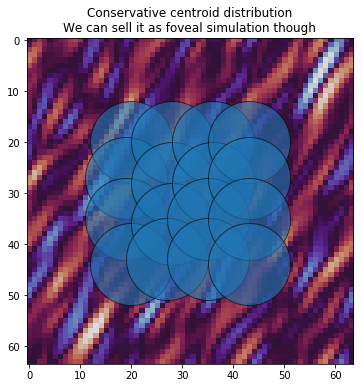

In [9]:
distrib_size = 10
safeguard_offset = 2 * distrib_size

video = np.load('./MotionClouds_64x64x128_24FPS.npy')
video.shape

coor = SpiLGN.generate_centers_coordinates(
        distrib_size=distrib_size, safeguard_offset = safeguard_offset, random_shift = 1, video=video)


fig = plt.figure(figsize = (8,6))

#la taille des points n'est pas une science exacte
plt.scatter(coor[0], coor[1], s = 82**2, edgecolor = 'black', alpha = .6) 


plt.imshow(video[:,:,0], cmap = plt.cm.twilight)
plt.title('Conservative centroid distribution\nWe can sell it as foveal simulation though')

En lisant directement l'output du terminal, la methode conservative donne
## 329 filtres virés par thread d'orientation

In [10]:
output_currents = SpiLGN.input_to_currents(video=video, FPS=24, total_time=1000,
                                           distrib_size=distrib_size, safeguard_offset=safeguard_offset,
                                           random_shift=1, grid_res=3,
                                           N_theta=12, B_theta=15, sf_0=.05, B_sf=.5,
                                           on_thresh=0, off_thresh=0,
                                           filter_size=2., filter_res=.1,
                                           sampling_rate = 1,
                                           n_jobs=-1, backend='loky', mt_verbose=50,
                                          off_gain = 'auto')

Video shape (64, 64, 128)
Frames per second: 24
Frame duration at 24 FPS: 41.67 ms
Video length inferred from fps: 6 s
FPS conversion sanity check passed !

Stimuli shape (64, 64, 1000)
Generating filters coordinates with gabors ..
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:   46.9s remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:   46.9s remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:   48.8s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:   49.0s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:   49.2s remaining:   49.2s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:   49.3s remaining:   35.2s
[Parallel(n_jobs=-1)]: Done   8 out of  12 | elapsed:   49.7s remaining:   24.8s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  1.2min r

La méthode classique quant à elle 
## 681 filtres virés par thread d'orientation

output_currents = SpiLGN.input_to_currents(video=video, FPS=24, total_time=1000,
                                           distrib_size=10, safeguard_offset=12,
                                           random_shift=1, grid_res=3,
                                           N_theta=12, B_theta=15, sf_0=.05, B_sf=.5,
                                           on_thresh=0, off_thresh=0,
                                           filter_size=2., filter_res=.1,
                                           sampling_rate = 1,
                                           n_jobs=-1, backend='loky', mt_verbose=50)

Et en étant ultra conservateur :
## 76 filtres virés par thread d'orientation

distrib_size = 10
safeguard_offset = 4 * distrib_size

output_currents = SpiLGN.input_to_currents(video=video, FPS=24, total_time=1000,
                                           distrib_size=distrib_size, safeguard_offset=safeguard_offset,
                                           random_shift=1, grid_res=3,
                                           N_theta=12, B_theta=15, sf_0=.05, B_sf=.5,
                                           on_thresh=0, off_thresh=0,
                                           filter_size=2., filter_res=.1,
                                           sampling_rate = 1,
                                           n_jobs=-1, backend='loky', mt_verbose=50)

Sauf que c'est un effet de diminution du nombre de centroides :

In [11]:
329/76

4.328947368421052

Donc on diminue juste le nombre de calculs par le nombre de fautes par calcul

# Troisième test, débugging du code
Avec une réduction du nombre de centroides pour simplifier les calculs

In [12]:
frame_duration = int(total_time/FPS)
stimuli = []
for ms in range(int(total_time/frame_duration)):
    for same_frame in range(frame_duration):
        stimuli.append(video[:, :, ms])
while len(stimuli) < total_time:
    stimuli.append(stimuli[-1])
if stimuli[0][30, 30] != stimuli[frame_duration+1][30, 30] :
    print('FPS difference sanity check passed !\n')
if stimuli[456][30, 30] == stimuli[457][30, 30] :
    print('FPS identity sanity check passed !\n')

#print(np.swapaxes(np.asarray(stimuli).T, 0,1).shape)
stimuli = np.swapaxes(np.asarray(stimuli).T, 0, 1)
print('Stimuli shape',stimuli.shape)

FPS difference sanity check passed !

FPS identity sanity check passed !

Stimuli shape (64, 64, 1000)


Centers coordinates shape (2, 16)


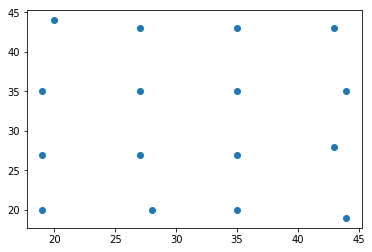

In [13]:
distrib_size = 10
safeguard_offset = 2 * distrib_size
random_shift = 1
stimuli
centers_coordinates = SpiLGN.generate_centers_coordinates(
        distrib_size, safeguard_offset, random_shift, stimuli)

print('Centers coordinates shape', centers_coordinates.shape)

plt.scatter(centers_coordinates[0], centers_coordinates[1])

In [14]:
gabor_coordinates = []

gabor_params = {'B_sf': 0.4, 'B_theta': 0.17453277777777776, 'N_X': 256, 'N_Y': 256,
                         'N_image': 100, 'base_levels': 1.618, 'datapath': 'database', 'do_mask': True,
                         'do_whitening': True, 'dpi': 450, 'edgefigpath': 'results/edges', 'edgematpath': 'cache_dir/edges',
                         'ext': '.pdf', 'figpath': 'results', 'figsize': 14.0, 'formats': ['pdf', 'png', 'jpg'],
                         'mask_exponent': 3.0, 'matpath': 'cache_dir', 'n_theta': 24, 'noise': 0.1, 'seed': None,
                         'use_cache': True, 'verbose': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_alpha': 1.4,
                         'white_f_0': 0.4, 'white_n_learning': 0, 'white_name_database': 'kodakdb',
                         'white_recompute': False, 'white_steepness': 4.0}
N_theta = 4 #simplifying it
B_theta = 15
sf_0=.05,
B_sf=.5
on_thresh=0
off_thresh=0
grid_res = 3

#no multithreading to have clearer view
for theta in tqdm(np.linspace(0, np.pi, N_theta)):
    gabor_coordinate = SpiLGN.generate_gabors_coordinates(theta,
                                      params=gabor_params,
                                      N_X=stimuli.shape[1], N_Y=stimuli.shape[0],
                                      centers_coordinates=centers_coordinates,
                                      B_theta=B_theta, sf_0=sf_0, B_sf=B_sf,
                                      on_thresh=on_thresh, off_thresh=off_thresh,
                                      distrib_size=distrib_size, grid_res=grid_res)
                                     
    gabor_coordinates.append(gabor_coordinate)
    
gabor_coordinates = np.asarray(gabor_coordinates)

  0%|          | 0/4 [00:00<?, ?it/s]

Thread started !
Filter grid shape (49, 2) 



 25%|██▌       | 1/4 [00:22<01:08, 22.92s/it]

Thread started !
Filter grid shape (49, 2) 



 50%|█████     | 2/4 [00:44<00:45, 22.63s/it]

Thread started !
Filter grid shape (49, 2) 



 75%|███████▌  | 3/4 [01:06<00:22, 22.41s/it]

Thread started !
Filter grid shape (49, 2) 



100%|██████████| 4/4 [01:28<00:00, 22.35s/it]


Text(0.5, 1.0, 'RF are actually overlapping but it matters not')

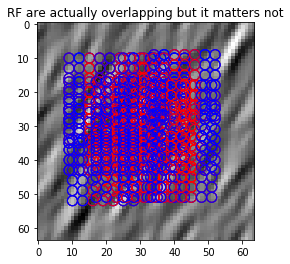

In [15]:
for theta in gabor_coordinates :
    for position in theta :

        filters_in_gabor = position[0]
        off_filters_in_gabor = position[1]
        for filt in filters_in_gabor :
            plt.scatter(filt[0], filt[1], color = 'r', s = 10**2, facecolor = 'None', edgecolor = 'red')

        for filt in off_filters_in_gabor :
            plt.scatter(filt[0], filt[1], color = 'r', s = 10**2, facecolor = 'None', edgecolor = 'blue')
    
plt.imshow(stimuli[:,:,0], cmap = plt.cm.binary)

plt.title('RF are actually overlapping but it matters not')

In [16]:
total_time = 500
filter_size = 2.
filter_res = .1
sampling_rate = 1

total_levels = []
#LOOPING THROUGH THETAS
for it, filters in  enumerate(gabor_coordinates) :
    print('----------\nCalculating for theta #', it )
    
    levels_per_gabor = []
    meta_err_nbr = 0 #variable that gets ALL the dumped filters nbr 
    
    #LOOPING THROUGH GABORS
    for it2, gabors in enumerate(filters):
        print('Doing gabor #',it2)
        filters_in_gabor, off_filters_in_gabor = gabors[0], gabors[1]

        # a number of aborted filters
        err_nbr = 0

        # On filters iteration
        st_list = []
        on_st_levels = []

        for filt in range(len(filters_in_gabor)):
                X, Y, Z = SpiLGN.spatial_filter(wx=filter_size, wy=filter_size,
                                         xres=filter_res, yres=filter_res,
                                         x_trans=filters_in_gabor[filt][0],
                                         y_trans=filters_in_gabor[filt][1])
                t = [SpiLGN.temporal_filter(i)
                     for i in np.linspace(0, total_time, int(total_time/sampling_rate))]
                
                # Convolution coordinates
                X_convo_minus = int(filters_in_gabor[filt][0]-filter_size)
                X_convo_plus = int(filters_in_gabor[filt][0]+filter_size)
                Y_convo_minus = int(filters_in_gabor[filt][1]-filter_size)
                Y_convo_plus = int(filters_in_gabor[filt][1]+filter_size)
                
                #difference between filter Z and convolution area, for upscaling
                n_downscale = int(Z.shape[0]/(X_convo_plus-X_convo_minus))
                
                activations = []
                for i in np.linspace(0, total_time-1, int(total_time/sampling_rate)):
                    #Kron upscaling
                    arr = stimuli[:, :, int(i)][X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus]
                    activations.append(np.max(homemade_kronecker(arr, n_downscale) * Z))

                ys = np.convolve(t, activations)
                st = Z[:, :, None] * ys[None, None, :]

                st_list.append(st)

                on_st_level = []
                for i in range(int(total_time/sampling_rate)):
                    on_st_level.append(np.max(st[:, :, i]) * sampling_rate)
                on_st_levels.append(on_st_level)
            

        # Off filters iterations
        st_list = []
        off_st_levels = []

        for filt in range(len(off_filters_in_gabor)):
                X, Y, Z = SpiLGN.spatial_filter(wx=filter_size, wy=filter_size,
                                         xres=filter_res, yres=filter_res,
                                         x_trans=off_filters_in_gabor[filt][0],
                                         y_trans=off_filters_in_gabor[filt][1],
                                         gain=1.)
                t = [SpiLGN.temporal_filter(i)
                     for i in np.linspace(0, total_time, int(total_time/sampling_rate))]

                X_convo_minus = int(off_filters_in_gabor[filt][0]-filter_size)
                X_convo_plus = int(off_filters_in_gabor[filt][0]+filter_size)
                Y_convo_minus = int(off_filters_in_gabor[filt][1]-filter_size)
                Y_convo_plus = int(off_filters_in_gabor[filt][1]+filter_size)
                
                #difference between filter Z and convolution area, for upscaling
                n_downscale = int(Z.shape[0]/(X_convo_plus-X_convo_minus))
                
                activations = []
                for i in np.linspace(0, total_time-1, int(total_time/sampling_rate)):
                    #Kron upscaling and filter max-ed convolution
                    arr = stimuli[:, :, int(i)][X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus]
                    activations.append(np.max(homemade_kronecker(arr, n_downscale) * Z))
            
                ys = np.convolve(t, activations)
                st = Z[:, :, None] * ys[None, None, :]

                st_list.append(st)

                off_st_level = []
                for i in range(int(total_time/sampling_rate)):
                    off_st_level.append(np.max(st[:, :, i]) * sampling_rate)
                off_st_levels.append(off_st_level)
            

        if err_nbr > 0:
            print('Due to misplacement, %s / %s filters were removed' %
                  (err_nbr, (len(filters_in_gabor)+len(off_filters_in_gabor))))
            meta_err_nbr+=err_nbr
            
        levels_per_gabor.append((on_st_levels, off_st_levels))
    print('Total errs ', meta_err_nbr)
    total_levels.append(levels_per_gabor)

----------
Calculating for theta # 0
Doing gabor # 0


NameError: name 'homemade_kronecker' is not defined

In [ ]:
total_levels = np.asarray(total_levels)

In [ ]:
plt.plot(total_levels[0][0][0][0])
plt.title('Fuck yes ça marche champagne')

## Le pb doit venir d'une taille de matrice 4 vs 40

In [ ]:
def homemade_kronecker(arr, n):
    '''
    Homemade kronecker product of two arrays, used here to upscale the simulus
    It's 12 µs faster than numpy's, which is significant given how many kron product
    we'll have to do
    '''
    
    kr = np.repeat(arr, n* np.ones(arr.shape[0], np.int), axis = 0)
    kr = np.repeat(kr, n* np.ones(arr.shape[0], np.int), axis = 1)
    
    return kr

In [ ]:
a = stimuli[:, :, int(i)][X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus]

n = int(Z.shape[0]/(X_convo_plus-X_convo_minus))

In [ ]:
%%timeit
kron_maison = np.repeat(a, n* np.ones(a.shape[0], np.int), axis = 0)
kron_maison = np.repeat(kron_maison, n* np.ones(a.shape[0], np.int), axis = 1)

In [ ]:
%%timeit
kr = np.kron(a, np.ones((n,n)))

In [ ]:
fig, axs = plt.subplots(1, 2)
axs[0].set_title('Fait a la main')
axs[0].imshow(kron_maison)
axs[1].set_title('Built-in')
axs[1].imshow(kr)

In [ ]:
print(Y.min(), Y.max())
print(X.min(), X.max())

In [ ]:
stimuli[:,:,(int(i))][X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus].shape

In [ ]:
Z[X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus].shape

In [ ]:
print('X_convo_minus :',X_convo_minus )
print('X_convo_plus :',X_convo_plus )
print('Y_convo_minus :',Y_convo_minus )
print('Y_convo_plus :',Y_convo_plus )
Z.shape

NameError: name 'X' is not defined

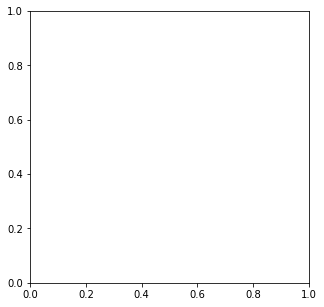

In [4]:
import matplotlib.patches as patches
fig, ax = plt.subplots(figsize = (5,5))
ax.contourf(X,Y,Z, alpha = .5)

ax.imshow(stimuli[:,:,0], cmap = plt.cm.binary)

ax.add_patch(patches.Rectangle((X_convo_minus, Y_convo_minus),
                               X_convo_plus-X_convo_minus, Y_convo_plus-Y_convo_minus, color = 'red', fill = False))
plt.show()

In [17]:
#the loading method is a bit different as the npz can dump multiple arrays
load_npz = np.load('./output/Use_this_one.npz')
load_arr = load_npz['arr_0.npy'] #won't contain more than one array normally

In [18]:
#We show the second Theta (here pi/4) and third gabor (i.e. simple cell)
theta_display = 1
gabor_display = 3
on_st_levels = output_currents[theta_display][gabor_display][0]
off_st_levels = output_currents[theta_display][gabor_display][1]

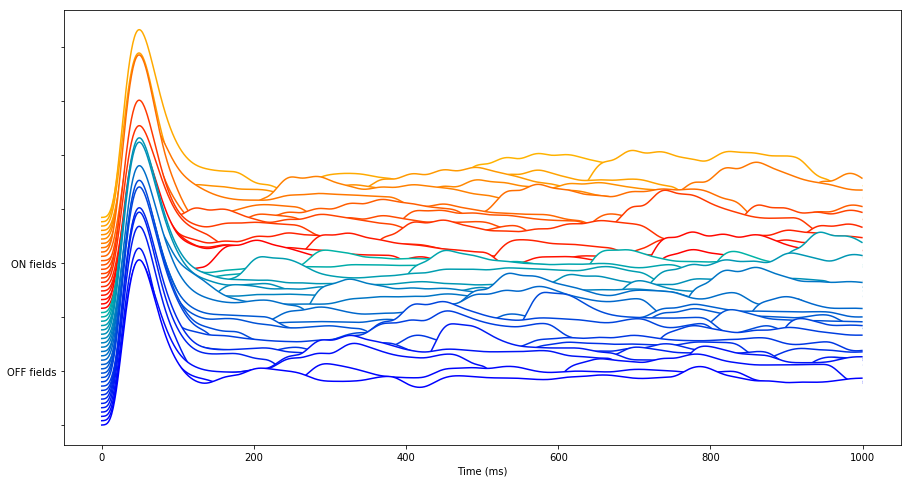

In [19]:
import matplotlib.pyplot as plt
chans = len(on_st_levels) + len(off_st_levels) #channels

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

ax.set_facecolor('white')

on_colors=plt.cm.autumn(np.linspace(0,.7,len(on_st_levels)))
off_colors=plt.cm.winter(np.linspace(0,.7,len(off_st_levels)))

on_arr = np.asarray(on_st_levels)
off_arr = np.asarray(off_st_levels)
divby = 25

for channel in range(chans):
    if channel < len(off_st_levels) :
        plt.fill_between(np.linspace(0, len(on_st_levels[0]), len(on_st_levels[0])),
                         off_arr[channel]+channel/divby, channel/divby,
                         facecolor='white',
                         zorder = chans-channel)
        plt.plot(off_arr[channel]+channel/divby, zorder = chans-channel,
                color = off_colors[channel])
    else : 
        plt.fill_between(np.linspace(0, len(off_st_levels[0]), len(off_st_levels[0])),
                         on_arr[channel-len(off_st_levels)]+channel/divby, channel/divby,
                         facecolor='white',
                         zorder = chans-channel)
        plt.plot(on_arr[channel-len(off_st_levels)]+channel/divby, zorder = chans-channel,
                color = on_colors[channel-len(off_st_levels)])
        

ax.set_yticklabels(['','','OFF fields','','' 'ON fields'])
ax.set_xlabel('Time (ms)')
#plt.savefig('./figs/2018_11_08_Script_output_white.pdf', dpi = 200, bbox_inches = 'tight')
plt.show() 

Text(0.5, 0.98, 'On a un petit problème de gain par contre')

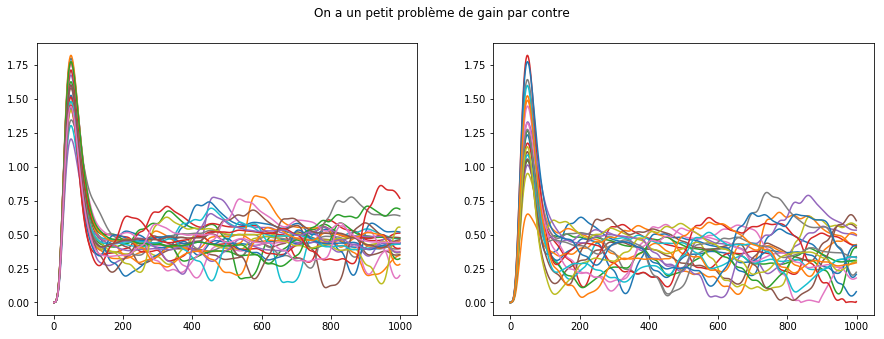

In [20]:
fig, axs = plt.subplots(ncols = 2, figsize = (15,5))
for off in off_st_levels :
    axs[0].plot(off)
    
for on in on_st_levels:
    axs[1].plot(on)
    
plt.suptitle('On a un petit problème de gain par contre')

In [ ]:
off_gain = np.max(on_st_levels) / np.max(off_st_levels)

In [ ]:
off_gain

In [ ]:
np.max(np.asarray(off) * off_gain)

In [ ]:
for off in off_st_levels :
    plt.plot(np.asarray(off)*off_gain)